In [5]:

import numpy as py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from  sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor
from datetime import datetime



import warnings 
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('Customer_Segmentation.csv')
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
counts_missing = df.isnull().sum()
missing_percentage = (counts_missing / len(df)) * 100

In [4]:
#summary of missing values
missing_summary = pd.DataFrame({
    'Missing Values': counts_missing,
    'Percentage': missing_percentage
}).reset_index().rename(columns={'index': 'Column'})
print(missing_summary)

                 Column  Missing Values  Percentage
0                    ID               0    0.000000
1            Year_Birth               0    0.000000
2             Education               0    0.000000
3        Marital_Status               0    0.000000
4                Income              24    1.071429
5               Kidhome               0    0.000000
6              Teenhome               0    0.000000
7           Dt_Customer               0    0.000000
8               Recency               0    0.000000
9              MntWines               0    0.000000
10            MntFruits               0    0.000000
11      MntMeatProducts               0    0.000000
12      MntFishProducts               0    0.000000
13     MntSweetProducts               0    0.000000
14         MntGoldProds               0    0.000000
15    NumDealsPurchases               0    0.000000
16      NumWebPurchases               0    0.000000
17  NumCatalogPurchases               0    0.000000
18    NumSto

In [5]:
#we decided to use median impoutation for the missing values in Income column.This is because of the following reasons
#1. Median is robust to outliers, which is important for income data that may have extreme values.
#2. It preserves the distribution of the data better than mean imputation.
df['Income'].fillna(df['Income'].median(), inplace=True)
print(df["Income"].isnull().sum()) 


0


In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y', errors='coerce')
print("First 20 enrollment dates:")
print(df['Dt_Customer'].head(20))

First 20 enrollment dates:
0    2012-09-04
1    2014-03-08
2    2013-08-21
3    2014-02-10
4    2014-01-19
5    2013-09-09
6    2012-11-13
7    2013-05-08
8    2013-06-06
9    2014-03-13
10   2013-11-15
11   2012-11-13
12   2013-11-15
13   2013-11-15
14   2012-10-10
15   2012-11-24
16   2012-12-24
17   2012-08-31
18   2013-03-28
19   2012-11-03
Name: Dt_Customer, dtype: datetime64[ns]


In [8]:
#identifying outliers using IQR method
# list of Outlier 
def outlier_summary(dataframe):
     # Get numerical columns (excluding ID )
    numerical_cols = dataframe.select_dtypes(include=[py.number]).columns.tolist()
    if 'ID' in numerical_cols:
        numerical_cols.remove('ID')
    
    
    outlier_info = []
    total_outliers = 0
    
    for col in numerical_cols:
        # Calculate IQR
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Find outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
        outlier_count = len(outliers)
        
        if outlier_count > 0:
            outlier_percentage = (outlier_count / len(dataframe)) * 100
            outlier_info.append((col, outlier_count, outlier_percentage))
            total_outliers += outlier_count
    
    print(f"Columns with outliers: {len(outlier_info)}")
    print(f"Total outliers: {total_outliers}")
    
    if outlier_info:
        print("Columns with outliers:")
        print()
        # Sort by outlier count (descending)
        #outlier_info.sort(key=lambda x: x[1], reverse=True)
        
        for col, count, percentage in outlier_info:
            print(f"{col}: {count} outliers ({percentage:.1f}%)")
    else:
        print("No outliers detected in any column!")

# Run the outlier summary
outlier_summary(df)


Columns with outliers: 19
Total outliers: 2269
Columns with outliers:

Year_Birth: 3 outliers (0.1%)
Income: 8 outliers (0.4%)
MntWines: 35 outliers (1.6%)
MntFruits: 227 outliers (10.1%)
MntMeatProducts: 175 outliers (7.8%)
MntFishProducts: 223 outliers (10.0%)
MntSweetProducts: 248 outliers (11.1%)
MntGoldProds: 207 outliers (9.2%)
NumDealsPurchases: 86 outliers (3.8%)
NumWebPurchases: 4 outliers (0.2%)
NumCatalogPurchases: 23 outliers (1.0%)
NumWebVisitsMonth: 8 outliers (0.4%)
AcceptedCmp3: 163 outliers (7.3%)
AcceptedCmp4: 167 outliers (7.5%)
AcceptedCmp5: 163 outliers (7.3%)
AcceptedCmp1: 144 outliers (6.4%)
AcceptedCmp2: 30 outliers (1.3%)
Complain: 21 outliers (0.9%)
Response: 334 outliers (14.9%)


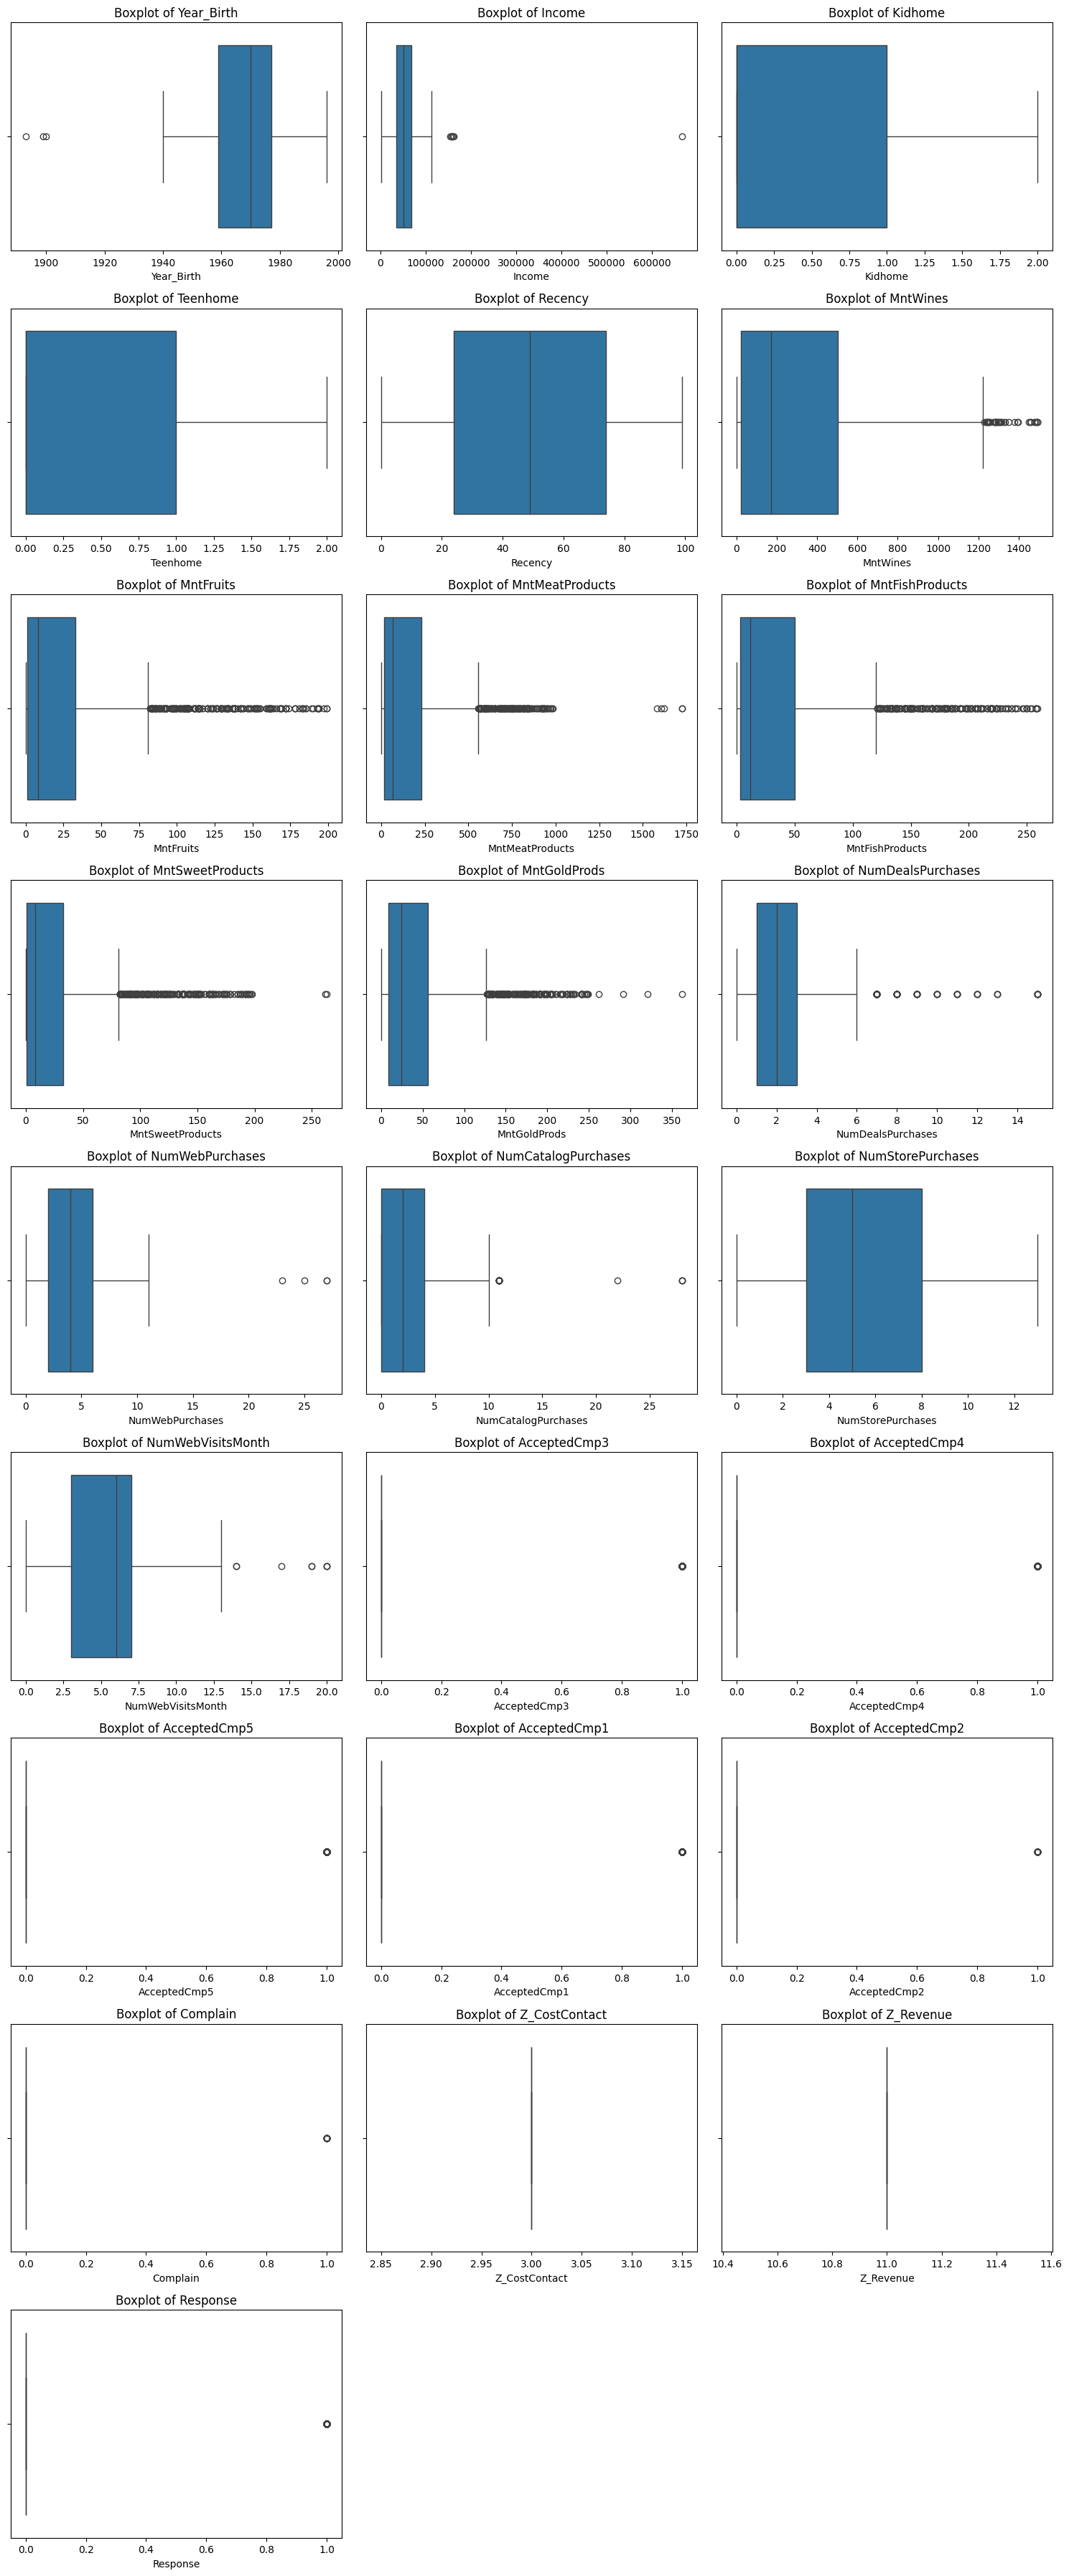

In [9]:
#visualize the outliers using boxplots
def plot_outliers(dataframe):
    
    
    numerical_cols = dataframe.select_dtypes(include=[py.number]).columns.tolist()
    
    if 'ID' in numerical_cols:
        numerical_cols.remove('ID')
    
    n_cols = 3
    n_plots = len(numerical_cols)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sb.boxplot(x=dataframe[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()
# Run the outlier visualization
plot_outliers(df)

In [ ]:
#handling the outliers
import numpy as np

# Capping method to handle outliers
def cap_outliers(dataframe):

    df_capped = dataframe.copy()
    
    # Get numerical columns (excluding ID)
    numerical_cols = df_capped.select_dtypes(include=[np.number]).columns.tolist()
    if 'ID' in numerical_cols:
        numerical_cols.remove('ID')
    
    for col in numerical_cols:
        # Calculate IQR
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers before capping
        outliers_before = len(df_capped[(df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)])
        
        # Apply capping
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
        
        # Count outliers after capping
        outliers_after = len(df_capped[(df_capped[col] < lower_bound) | (df_capped[col] > upper_bound)])
        
        if outliers_before > 0:
            print(f"{col}: {outliers_before} outliers capped")
    
    print(f"\nOutlier capping completed!")
    return df_capped #return the capped DataFrame while preserving the original DataFrame

# Apply capping to the dataset
df_capped = cap_outliers(df)





Year_Birth: 3 outliers capped
Income: 8 outliers capped
MntWines: 35 outliers capped
MntFruits: 227 outliers capped
MntMeatProducts: 175 outliers capped
MntFishProducts: 223 outliers capped
MntSweetProducts: 248 outliers capped
MntGoldProds: 207 outliers capped
NumDealsPurchases: 86 outliers capped
NumWebPurchases: 4 outliers capped
NumCatalogPurchases: 23 outliers capped
NumWebVisitsMonth: 8 outliers capped
AcceptedCmp3: 163 outliers capped
AcceptedCmp4: 167 outliers capped
AcceptedCmp5: 163 outliers capped
AcceptedCmp1: 144 outliers capped
AcceptedCmp2: 30 outliers capped
Complain: 21 outliers capped
Response: 334 outliers capped

Outlier capping completed!


Boxplots of capped data only:


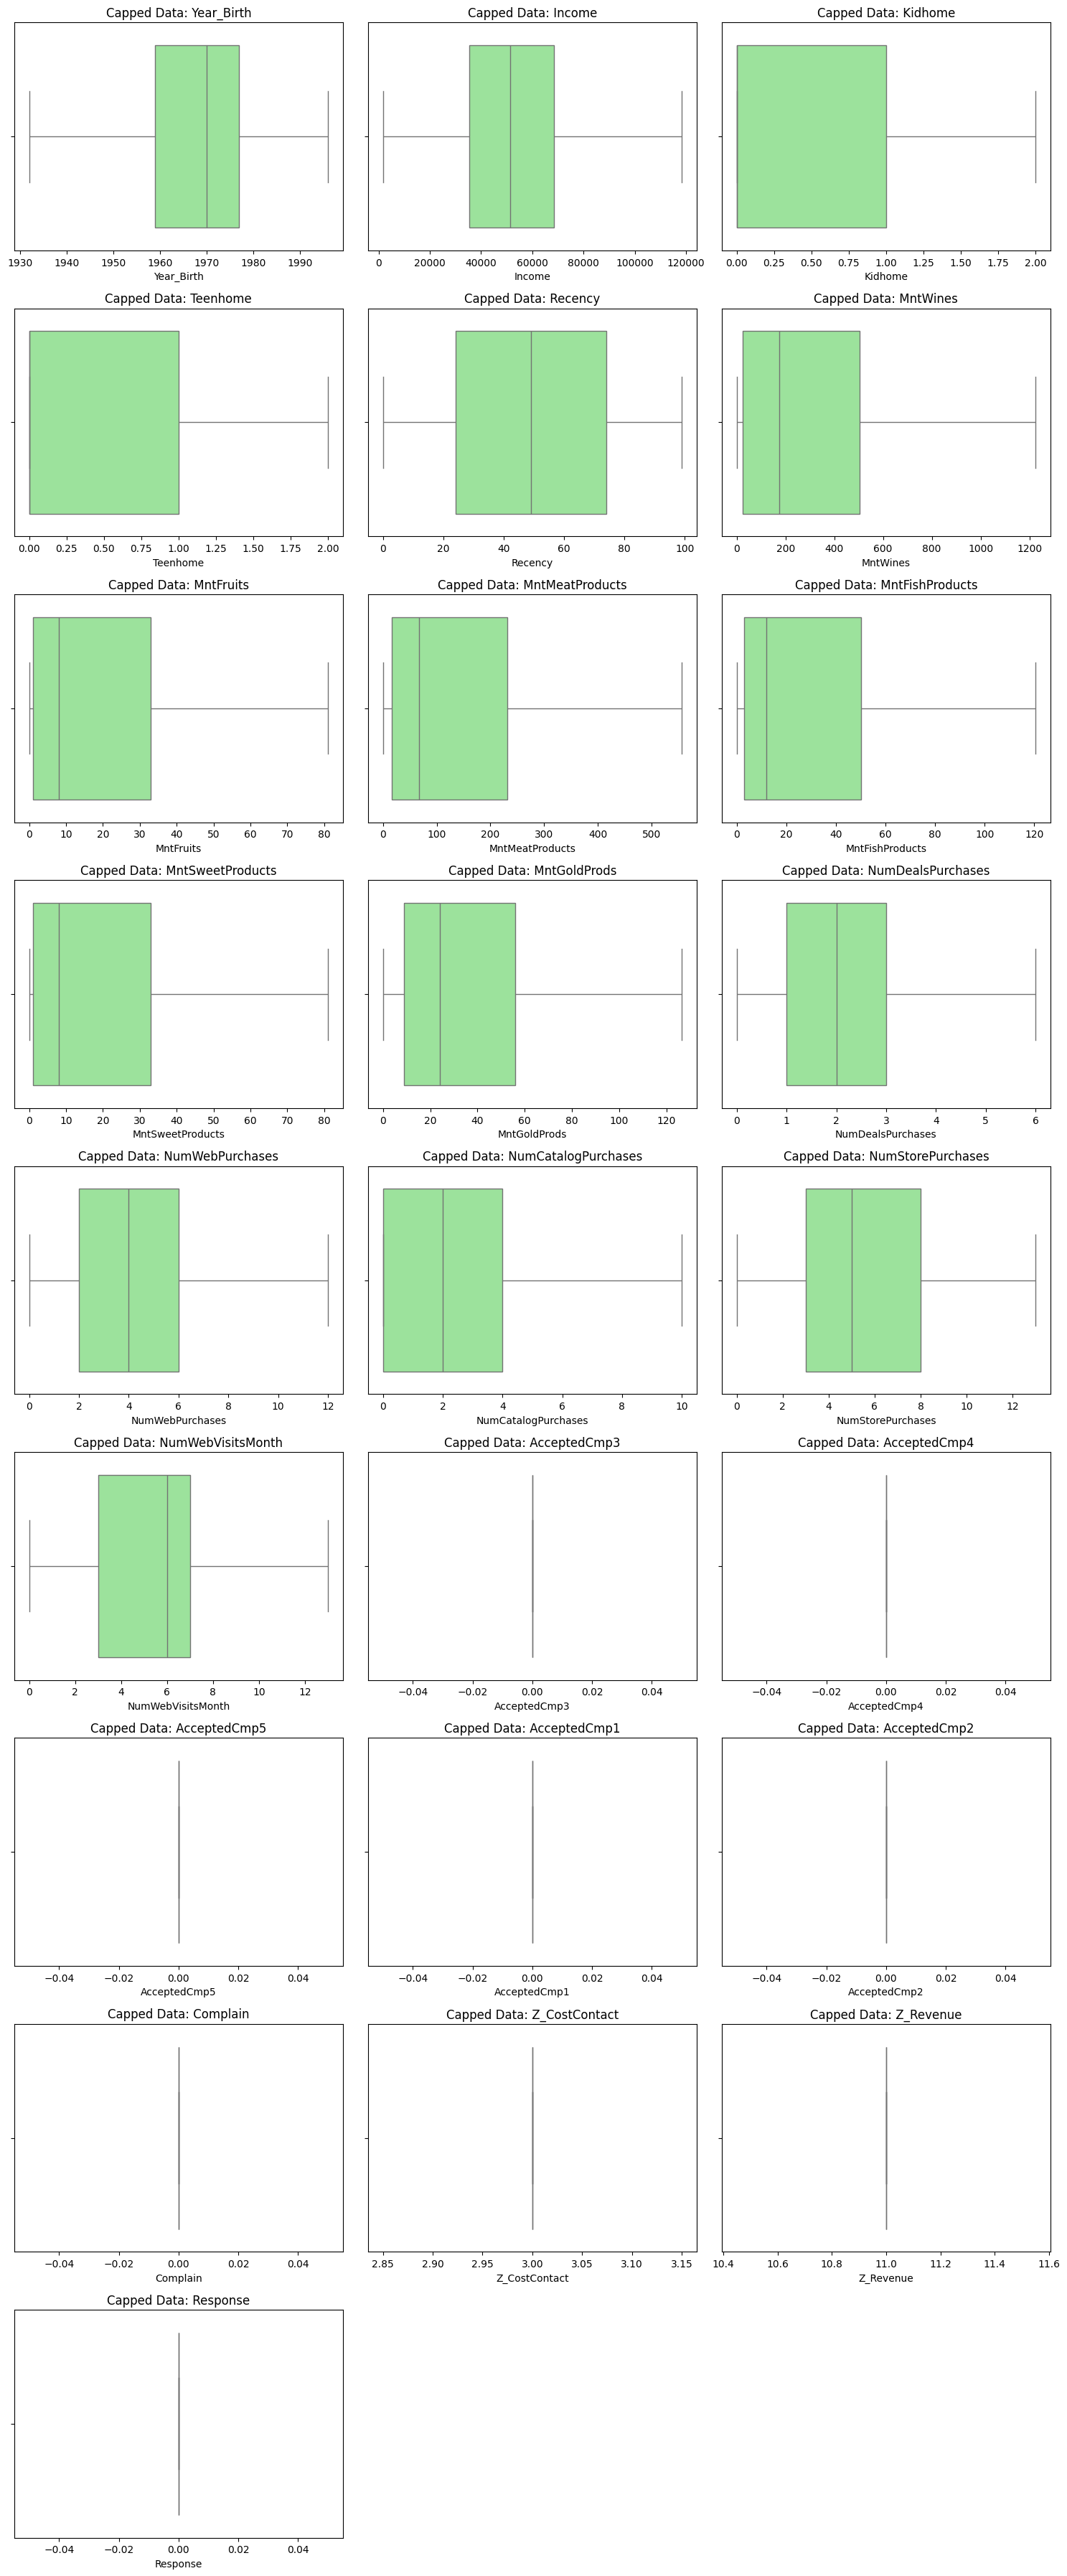

In [9]:


# Also created a simple boxplot of just the capped data
def plot_capped_data_only(capped_df):

    numerical_cols = capped_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'ID' in numerical_cols:
        numerical_cols.remove('ID')
    
    n_cols = 3
    n_plots = len(numerical_cols)
    n_rows = (n_plots + n_cols - 1) // n_cols

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sb.boxplot(x=capped_df[col], color='lightgreen')
        plt.title(f'Capped Data: {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

print("Boxplots of capped data only:")
plot_capped_data_only(df_capped)


In [12]:
# Save the cleaned dataset with capped outliers
df_capped.to_csv('cleaned_customer_segmentation.csv', index=False)
print("Cleaned dataset saved as 'cleaned_customer_segmentation.csv'")
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_capped.shape}")

# Verify the file was saved
import os
if os.path.exists('cleaned_customer_segmentation.csv'):
    print("✓ File successfully saved!")
    file_size = os.path.getsize('cleaned_customer_segmentation.csv') / 1024  # Size in KB
    print(f"File size: {file_size:.2f} KB")

else:
    print("✗ Error: File was not saved!")

Cleaned dataset saved as 'cleaned_customer_segmentation.csv'
Original dataset shape: (2240, 29)
Cleaned dataset shape: (2240, 29)
✓ File successfully saved!
File size: 227.90 KB


In [13]:

# Identify constant columns
df=pd.read_csv('cleaned_customer_segmentation.csv')
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

# Remove constant columns
df = df.drop(columns=constant_columns)

print(f"Removed {len(constant_columns)} constant columns: {constant_columns}")

Removed 9 constant columns: ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


In [ ]:
#from the above dataset,we were able to obtain the following features:

# df['Age'] = 2025- df['Year_Birth']
# df['Total_Children'] = df['Kidhome'] + df['Teenhome']
# df['Total_Spending'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
# df['Total_Purchases'] = df[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1)
# df['Tenure_Days'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days.......calculates how many days each customer has been enrolled in your system by measuring the time between today's date and their enrollment date (Dt_Customer).

In [14]:

# Load data
df = pd.read_csv('cleaned_customer_segmentation.csv')

# Feature engineering with corrected date parsing
try:
    
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed', dayfirst=True)
except ValueError:
    
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y', errors='coerce')


df['Age'] = 2025- df['Year_Birth']
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Total_Spending'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
df['Total_Purchases'] = df[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1)
df['Tenure_Days'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days

# Handle missing values
df['Income'] = df['Income'].fillna(df['Income'].median())

# Verify date conversion
print("\nDate conversion samples:")
print(df[['Dt_Customer', 'Tenure_Days']].head())

# Drop unnecessary columns
df = df.drop(['ID', 'Year_Birth', 'Z_CostContact', 'Z_Revenue'], axis=1, errors='ignore')

# Encode categorical variables
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)



Date conversion samples:
  Dt_Customer  Tenure_Days
0  2012-09-04         4691
1  2014-03-08         4141
2  2013-08-21         4340
3  2014-02-10         4167
4  2014-01-19         4189


In [15]:
print("\nFirst 10 rows with all columns:")
print(df.head(10).to_string())


First 10 rows with all columns:
    Income  Kidhome  Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  Age  Total_Children  Total_Spending  Total_Purchases  Tenure_Days  Education_Basic  Education_Graduation  Education_Master  Education_PhD  Marital_Status_Alone  Marital_Status_Divorced  Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  Marital_Status_Widow  Marital_Status_YOLO
0  58138.0        0         0  2012-09-04       58       635         81              546            120.5                81          88.0                  3                8                   10                  4                  7             0             0             0             0             0         0         0   68               0


--- Feature Engineering: Aggregate Spending & Purchases ---
                  count        mean         std  min    25%    50%    75%  \
Total_Spent      2240.0  568.206696  547.036742  5.0  68.75  395.0  990.5   
Total_Purchases  2240.0   14.690625    7.472104  0.0   8.00   15.0   21.0   

                    max  
Total_Spent      2099.5  
Total_Purchases    35.0  


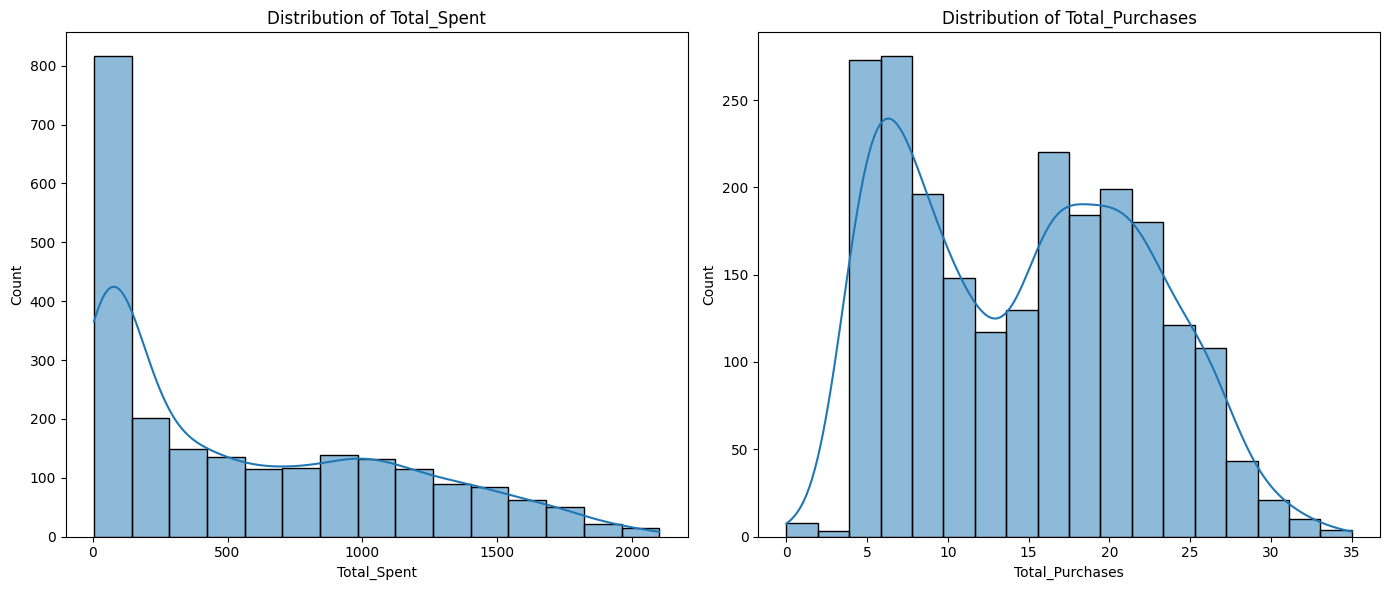

In [18]:
print("\n--- Feature Engineering: Aggregate Spending & Purchases ---")
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spent'] = df[mnt_cols].sum(axis=1)

num_purchases_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[num_purchases_cols].sum(axis=1)

print(df[['Total_Spent', 'Total_Purchases']].describe().T)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sb.histplot(df['Total_Spent'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Total_Spent')
sb.histplot(df['Total_Purchases'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Total_Purchases')
plt.tight_layout()
plt.show()

In [19]:
print("\n--- Feature Engineering: Household & Campaign Aggregates ---")
df['Total_Dependents'] = df['Kidhome'] + df['Teenhome']
print(df['Total_Dependents'].value_counts().sort_index())

# Creating binary flag for parents
df['Is_Parent'] = (df['Total_Dependents'] > 0).astype(int)
print(df['Is_Parent'].value_counts())


--- Feature Engineering: Household & Campaign Aggregates ---
Total_Dependents
0     638
1    1128
2     421
3      53
Name: count, dtype: int64
Is_Parent
1    1602
0     638
Name: count, dtype: int64


In [11]:
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Total_Accepted_Campaigns'] = df[campaign_cols].sum(axis=1)
df['Ever_Accepted_Campaign'] = (df['Total_Accepted_Campaigns'] > 0).astype(int)

#Drop unwanted columns if they still exist

columns_to_drop = ['Z_Revenue', 'Z_CostContact']  # or 'Z_Contact' if that's the correct column name
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
print("\n--- Feature Engineering: Campaigns ---")
print(df['Total_Accepted_Campaigns'].value_counts().sort_index())
print(df['Ever_Accepted_Campaign'].value_counts())


--- Feature Engineering: Campaigns ---
Total_Accepted_Campaigns
0    1777
1     325
2      83
3      44
4      11
Name: count, dtype: int64
Ever_Accepted_Campaign
0    1777
1     463
Name: count, dtype: int64



--- Generating Correlation Heatmap for Reduced Features ---


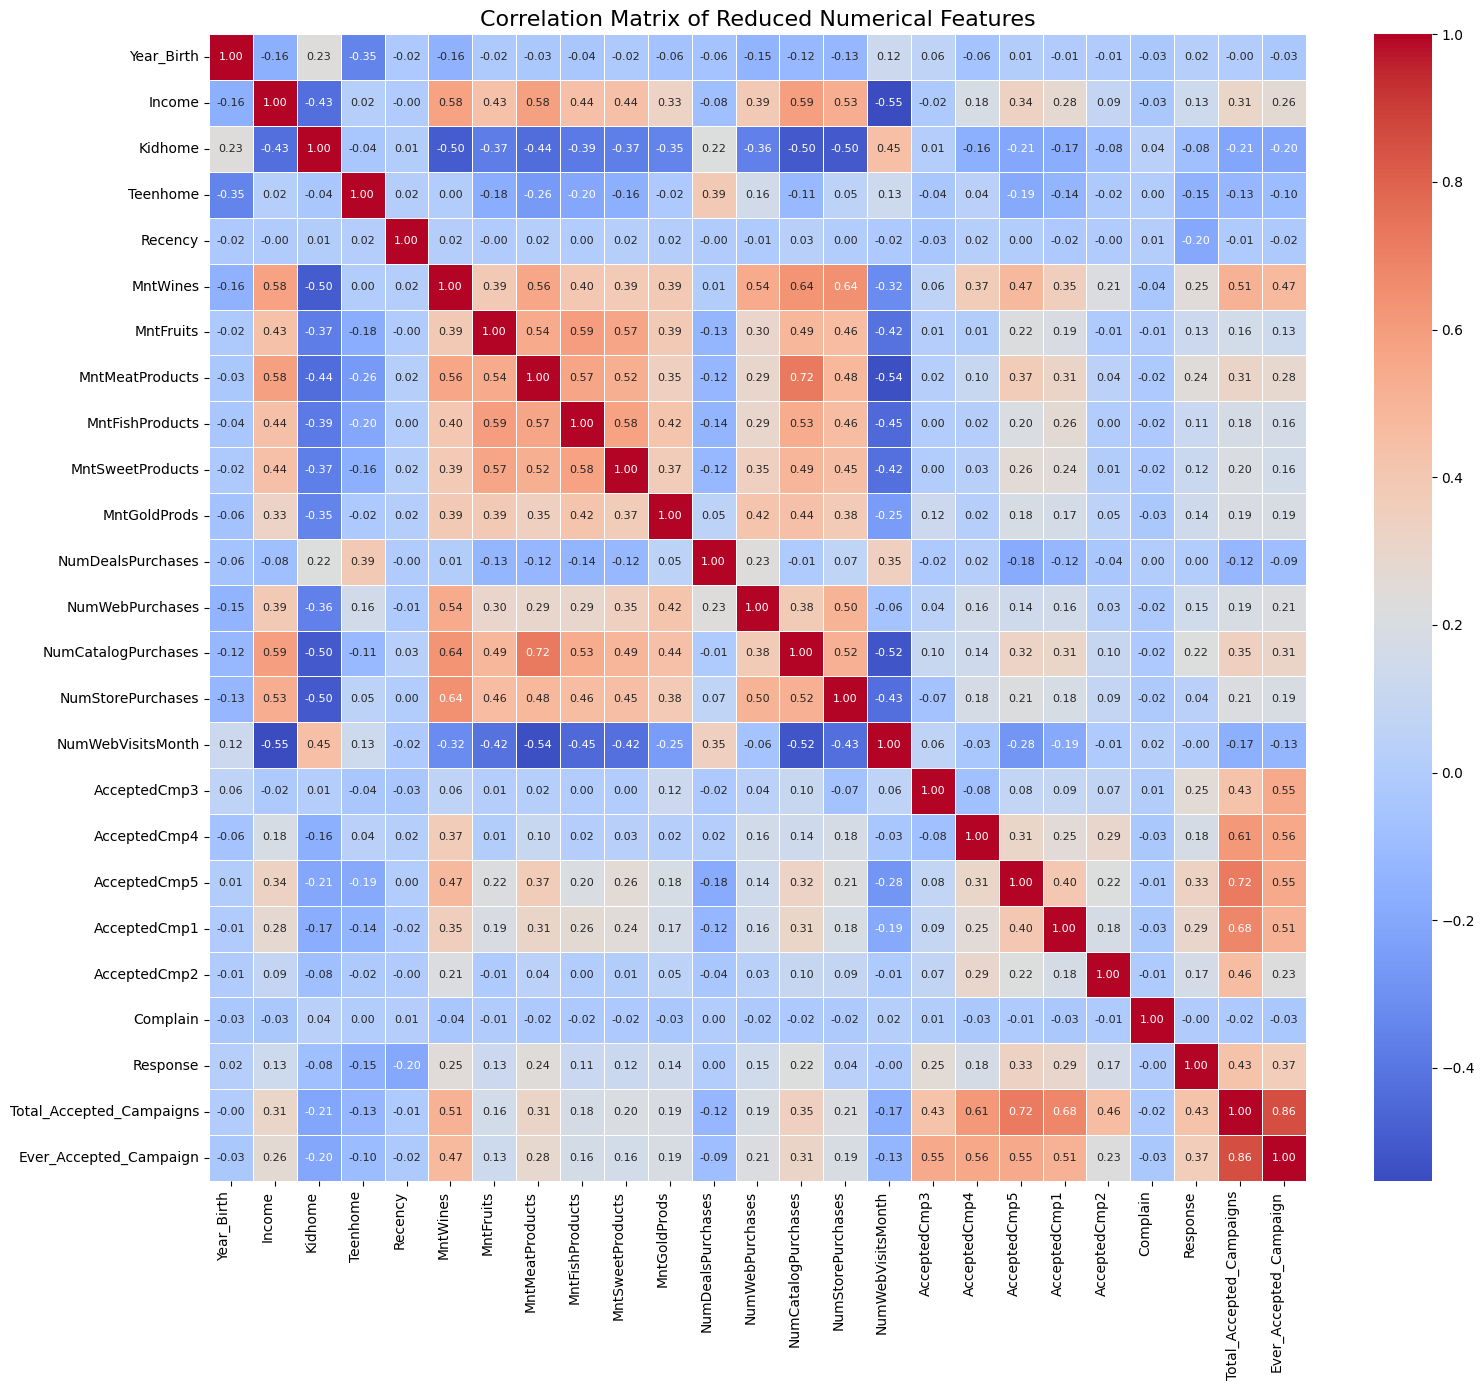


--- Key Observations from Heatmap ---
Look for:
1. High correlations (close to 1 or -1) between remaining features.
2. Correlations between potential features and your target variable (if it's numerical and included).


In [12]:
print("\n--- Generating Correlation Heatmap for Reduced Features ---")

# Select only numerical columns for the correlation matrix
# (Categorical columns like 'Education', 'Marital_Status' need to be encoded first
# if you want them in the correlation, but for a numerical heatmap, just pick numbers)
numerical_cols_for_heatmap = df.select_dtypes(include=np.number).columns.tolist()

if 'ID' in numerical_cols_for_heatmap:
    numerical_cols_for_heatmap.remove('ID')

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols_for_heatmap].corr()

# Set up the matplotlib figure for the heatmap
plt.figure(figsize=(16, 14)) # Adjust size as needed; 16x14 is a good starting point for moderate features

# Create the heatmap
sb.heatmap(correlation_matrix,
            annot=True,        # Show the correlation values on the heatmap
            cmap='coolwarm',   # Color map (coolwarm is good for showing positive/negative correlations)
            fmt=".2f",         # Format annotation to 2 decimal places
            linewidths=.5,     # Add lines between cells for better separation
            annot_kws={"size": 8}) # Adjust annotation font size if text overlaps

plt.title('Correlation Matrix of Reduced Numerical Features', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10) # Rotate x-axis labels for readability
plt.yticks(rotation=0, fontsize=10) # Keep y-axis labels horizontal
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

print("\n--- Key Observations from Heatmap ---")
print("Look for:")
print("1. High correlations (close to 1 or -1) between remaining features.")
print("2. Correlations between potential features and your target variable (if it's numerical and included).")